<a href="https://colab.research.google.com/github/dimitarpg13/agentic_architectures_and_design_patterns/blob/main/notebooks/reinforcement_learning/multi_agent_colab/agentic_rl_workflow_worker_pool_semaphore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agentic Workflow with RL using Worker Pool & Semaphore

This notebook demonstrates a sophisticated multi-agent system where agents learn optimal behaviors through reinforcement learning, using the **Worker Pool + Semaphore** pattern for controlled parallel task execution.

## Complete Feature Set

This enhanced version includes all production components:
- **Worker Pool + Semaphore Pattern**: Controlled parallel execution
- **AgenticRLSystem**: PPO-based training orchestration
- **ToolRegistry**: Agent tool management with Q-learning
- **PerformanceMonitor**: Comprehensive visualization dashboard
- **train_agentic_rl_system()**: Complete training pipeline
- **ProductionAgenticSystem**: Production-ready deployment patterns

## Architecture Overview

```
┌─────────────────────────────────────────────────────────────────────────────┐
│        AGENTIC RL WORKFLOW - WORKER POOL + SEMAPHORE (COMPLETE)             │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│   ┌─────────────────┐                                                       │
│   │  RL ENVIRONMENT │ ◄── Generates tasks with random properties            │
│   └────────┬────────┘                                                       │
│            │                                                                │
│            ▼                                                                │
│   ┌─────────────────────────────────────────────────────────────────────┐   │
│   │                    AGENT WORKER POOL                                │   │
│   │  ┌───────────────────────────────────────────────────────────────┐  │   │
│   │  │         SEMAPHORE (max_concurrent_agents=N)                   │  │   │
│   │  │  ┌─────────┐  ┌─────────┐  ┌─────────┐  ┌─────────┐           │  │   │
│   │  │  │ Agent 1 │  │ Agent 2 │  │ Agent 3 │  │ Agent N │           │  │   │
│   │  │  │+Tools   │  │+Tools   │  │+Tools   │  │+Tools   │           │  │   │
│   │  │  └─────────┘  └─────────┘  └─────────┘  └─────────┘           │  │   │
│   │  └───────────────────────────────────────────────────────────────┘  │   │
│   │  ┌───────────────────────────────────────────────────────────────┐  │   │
│   │  │  ThreadPoolExecutor + AgenticRLSystem (PPO)                   │  │   │
│   │  └───────────────────────────────────────────────────────────────┘  │   │
│   └──────────────────────────────┬──────────────────────────────────────┘   │
│                                  │                                          │
│                                  ▼                                          │
│   ┌─────────────────────────────────────────────────────────────────────┐   │
│   │  PerformanceMonitor │ ToolRegistry │ ProductionAgenticSystem        │   │
│   └─────────────────────────────────────────────────────────────────────┘   │
└─────────────────────────────────────────────────────────────────────────────┘
```


## 1. Environment Setup and Dependencies


In [ ]:
# Install required packages
!pip install stable-baselines3 gymnasium numpy pandas matplotlib seaborn
!pip install langchain langchain-openai langgraph tensorboard
!pip install ray[rllib] wandb mlflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any, Union, Callable
from dataclasses import dataclass, field
from enum import Enum
import asyncio
import json
import logging
from datetime import datetime
import gymnasium
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Worker Pool + Semaphore Pattern imports
from threading import Semaphore, Lock
from concurrent.futures import ThreadPoolExecutor, Future
from abc import ABC, abstractmethod
import time

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ All imports loaded successfully")


✓ All imports loaded successfully


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. Core Data Structures


In [ ]:
class TaskStatus(Enum):
    """Task lifecycle states in the Worker Pool pattern"""
    PENDING = "pending"
    IN_PROGRESS = "in_progress"
    COMPLETED = "completed"
    FAILED = "failed"


class AgentRole(Enum):
    """Defines specialized agent roles in the system"""
    RESEARCHER = "researcher"
    ANALYZER = "analyzer"
    EXECUTOR = "executor"
    VALIDATOR = "validator"
    COORDINATOR = "coordinator"


@dataclass
class Task:
    """Represents a task in the RL workflow using Worker Pool pattern."""
    id: str
    type: str
    complexity: float
    requirements: List[str]
    deadline: float
    priority: float
    status: TaskStatus = TaskStatus.PENDING
    assigned_agent: Optional[str] = None
    result: Optional[Any] = None
    error: Optional[str] = None
    quality_score: Optional[float] = None
    start_time: Optional[float] = None
    completion_time: Optional[float] = None

    def mark_in_progress(self, agent_id: str) -> None:
        self.status = TaskStatus.IN_PROGRESS
        self.assigned_agent = agent_id
        self.start_time = time.time()

    def mark_completed(self, result: Any, quality: float) -> None:
        self.status = TaskStatus.COMPLETED
        self.result = result
        self.quality_score = quality
        self.completion_time = time.time()

    def mark_failed(self, error: str) -> None:
        self.status = TaskStatus.FAILED
        self.error = error
        self.completion_time = time.time()

    def get_processing_time(self) -> Optional[float]:
        if self.start_time and self.completion_time:
            return self.completion_time - self.start_time
        return None


@dataclass
class AgentState:
    """Tracks individual agent state for RL learning."""
    id: str
    role: AgentRole
    capacity: float
    expertise: Dict[str, float]
    current_load: float = 0.0
    completed_tasks: int = 0
    success_rate: float = 1.0
    collaboration_score: float = 1.0
    q_table: Dict[str, Dict[str, float]] = field(default_factory=dict)

    def get_match_score(self, task_type: str) -> float:
        return self.expertise.get(task_type, 0.5)

    def update_success_rate(self, quality: float) -> None:
        self.success_rate = 0.95 * self.success_rate + 0.05 * quality


print("✓ Core data structures defined")


✓ Core data structures defined


## 3. Agent Worker Pool with Semaphore


In [ ]:
class AgentWorkerPool:
    """Manages a pool of agent workers with semaphore-controlled concurrency."""

    def __init__(self, agents: List[AgentState], max_concurrent: int = 3):
        self.agents = {agent.id: agent for agent in agents}
        self.max_concurrent = max_concurrent
        self._semaphore = Semaphore(max_concurrent)
        self._lock = Lock()
        self._executor = ThreadPoolExecutor(max_workers=max_concurrent)
        self._tasks: Dict[str, Task] = {}
        self._results: List[Dict[str, Any]] = []
        self._active_count = 0
        self._total_tasks_processed = 0

    def acquire_slot(self) -> None:
        self._semaphore.acquire()
        with self._lock:
            self._active_count += 1

    def release_slot(self) -> None:
        with self._lock:
            self._active_count -= 1
        self._semaphore.release()

    def register_task(self, task: Task) -> None:
        with self._lock:
            self._tasks[task.id] = task

    def submit_task(self, task: Task, agent_id: str, execute_fn: Callable) -> Future:
        agent = self.agents.get(agent_id)
        if not agent:
            raise ValueError(f"Agent {agent_id} not found")
        return self._executor.submit(self._execute_with_semaphore, task, agent, execute_fn)

    def _execute_with_semaphore(self, task: Task, agent: AgentState, execute_fn: Callable) -> Dict:
        self.acquire_slot()
        try:
            task.mark_in_progress(agent.id)
            result = execute_fn(task, agent)
            quality = agent.get_match_score(task.type) * agent.success_rate
            task.mark_completed(result, quality)
            agent.current_load = max(0, agent.current_load - task.complexity)
            agent.completed_tasks += 1
            agent.update_success_rate(quality)
            self._record_result(task, agent, result, quality)
            return {"task_id": task.id, "agent_id": agent.id, "status": "completed",
                    "quality": quality, "processing_time": task.get_processing_time()}
        except Exception as e:
            task.mark_failed(str(e))
            self._record_failure(task, agent, str(e))
            return {"task_id": task.id, "agent_id": agent.id, "status": "failed", "error": str(e)}
        finally:
            self.release_slot()

    def _record_result(self, task, agent, result, quality):
        with self._lock:
            self._results.append({"task_id": task.id, "agent_id": agent.id, "quality": quality, "status": "completed"})
            self._total_tasks_processed += 1

    def _record_failure(self, task, agent, error):
        with self._lock:
            self._results.append({"task_id": task.id, "agent_id": agent.id, "error": error, "status": "failed"})
            self._total_tasks_processed += 1

    def get_stats(self) -> Dict:
        with self._lock:
            completed = sum(1 for t in self._tasks.values() if t.status == TaskStatus.COMPLETED)
            failed = sum(1 for t in self._tasks.values() if t.status == TaskStatus.FAILED)
            return {"max_concurrent": self.max_concurrent, "active": self._active_count,
                    "completed": completed, "failed": failed, "total_processed": self._total_tasks_processed}

    def shutdown(self):
        self._executor.shutdown(wait=True)

    def reset(self):
        with self._lock:
            self._tasks.clear()
            self._results.clear()
            self._total_tasks_processed = 0
            for agent in self.agents.values():
                agent.current_load = 0.0

print("✓ AgentWorkerPool defined")


✓ AgentWorkerPool defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 4. WORKER POOL RL ENVIRONMENT
# ═══════════════════════════════════════════════════════════════════════════════

class WorkerPoolRLEnvironment(gymnasium.Env):
    """Multi-agent RL environment using Worker Pool + Semaphore pattern."""

    def __init__(self, n_agents: int = 4, max_tasks: int = 10, max_concurrent: int = 3):
        super().__init__()
        self.n_agents = n_agents
        self.max_tasks = max_tasks
        self.max_concurrent = max_concurrent
        self.current_step = 0
        self.max_steps = 200

        self.agent_states = self._initialize_agents()
        self.worker_pool = AgentWorkerPool(self.agent_states, max_concurrent)
        self.pending_tasks: List[Task] = []
        self.completed_tasks: List[Task] = []

        obs_dim = n_agents * 7 + max_tasks * 5 + n_agents * n_agents
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(n_agents * 3,), dtype=np.float32)
        self.collaboration_matrix = np.ones((n_agents, n_agents))
        self.task_id_counter = 0

    def _initialize_agents(self) -> List[AgentState]:
        agents = []
        roles = list(AgentRole)[:self.n_agents]
        for i, role in enumerate(roles):
            expertise = {t: np.random.uniform(0.5, 1.0) for t in ["research", "analysis", "execution", "validation"]}
            role_boost = {AgentRole.RESEARCHER: "research", AgentRole.ANALYZER: "analysis",
                         AgentRole.EXECUTOR: "execution", AgentRole.VALIDATOR: "validation"}
            if role in role_boost:
                expertise[role_boost[role]] = min(1.0, expertise[role_boost[role]] + 0.3)
            agents.append(AgentState(id=f"agent_{i}", role=role, capacity=np.random.uniform(0.8, 1.0), expertise=expertise))
        return agents

    def _generate_task(self) -> Task:
        self.task_id_counter += 1
        task_types = ["research", "analysis", "execution", "validation"]
        return Task(id=f"task_{self.task_id_counter:04d}", type=np.random.choice(task_types),
                   complexity=np.random.uniform(0.3, 1.0), requirements=[],
                   deadline=np.random.uniform(10, 50), priority=np.random.uniform(0.1, 1.0))

    def _execute_task(self, task: Task, agent: AgentState) -> Dict:
        time.sleep(min(task.complexity * 0.05, 0.02))
        if np.random.random() < agent.get_match_score(task.type) * agent.capacity:
            return {"output": f"Completed {task.type}", "success": True}
        raise Exception("Task failed")

    def _get_observation(self) -> np.ndarray:
        obs = []
        for agent in self.agent_states:
            obs.extend([agent.capacity, agent.current_load, agent.completed_tasks / max(1, self.current_step),
                       agent.success_rate, agent.collaboration_score, agent.expertise.get("research", 0),
                       agent.expertise.get("analysis", 0)])
        for i in range(self.max_tasks):
            if i < len(self.pending_tasks):
                t = self.pending_tasks[i]
                obs.extend([t.complexity, t.priority, t.deadline, 1.0, 0.0])
            else:
                obs.extend([0, 0, 0, 0, 0])
        obs.extend(self.collaboration_matrix.flatten())
        return np.array(obs, dtype=np.float32)

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        self.current_step += 1
        action = action.reshape(self.n_agents, 3)
        reward = 0.0

        tasks_to_submit = []
        for i, agent in enumerate(self.agent_states):
            if len(self.pending_tasks) > 0 and action[i, 0] > 0.5:
                task = self.pending_tasks.pop(0)
                self.worker_pool.register_task(task)
                tasks_to_submit.append((task, agent.id))
                reward += agent.get_match_score(task.type) * task.priority * 2

        futures = [self.worker_pool.submit_task(t, aid, self._execute_task) for t, aid in tasks_to_submit]
        for future in futures:
            result = future.result()
            if result["status"] == "completed":
                reward += result.get("quality", 0.5) * 10
                self.completed_tasks.append(self.worker_pool._tasks[result["task_id"]])
            else:
                reward -= 2.0

        for i in range(self.n_agents):
            for j in range(self.n_agents):
                if i != j and action[i, 2] > 0.7 and action[j, 2] > 0.7:
                    self.collaboration_matrix[i, j] *= 1.01
                    reward += 0.5

        if np.random.random() < 0.3:
            self.pending_tasks.append(self._generate_task())
        reward -= len(self.pending_tasks) * 0.1

        done = self.current_step >= self.max_steps
        info = {"completed_tasks": len(self.completed_tasks), "pending_tasks": len(self.pending_tasks),
                "pool_stats": self.worker_pool.get_stats()}
        return self._get_observation(), reward, done, False, info

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        self.current_step = 0
        self.task_id_counter = 0
        self.agent_states = self._initialize_agents()
        self.worker_pool = AgentWorkerPool(self.agent_states, self.max_concurrent)
        self.pending_tasks = [self._generate_task() for _ in range(3)]
        self.completed_tasks = []
        self.collaboration_matrix = np.ones((self.n_agents, self.n_agents))
        return self._get_observation(), {}

    def close(self):
        self.worker_pool.shutdown()

print("✓ WorkerPoolRLEnvironment defined")


✓ WorkerPoolRLEnvironment defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 5. TOOL REGISTRY AND SMART AGENT
# ═══════════════════════════════════════════════════════════════════════════════

class ToolRegistry:
    """Registry for agent tools and capabilities"""

    def __init__(self):
        self.tools = {}
        self._register_default_tools()

    def _register_default_tools(self):
        self.register_tool("web_search", self._mock_web_search, "Search online", 0.1)
        self.register_tool("data_analysis", self._mock_data_analysis, "Analyze data", 0.2)
        self.register_tool("code_generation", self._mock_code_generation, "Generate code", 0.3)

    def register_tool(self, name: str, func, description: str, cost: float):
        self.tools[name] = {"function": func, "description": description, "cost": cost, "usage_count": 0}

    async def use_tool(self, tool_name: str, **kwargs) -> Dict[str, Any]:
        if tool_name not in self.tools:
            return {"error": f"Tool {tool_name} not found"}
        tool = self.tools[tool_name]
        tool["usage_count"] += 1
        try:
            result = await tool["function"](**kwargs)
            return {"success": True, "result": result, "cost": tool["cost"]}
        except Exception as e:
            return {"success": False, "error": str(e), "cost": tool["cost"]}

    async def _mock_web_search(self, query: str) -> str:
        await asyncio.sleep(0.01)
        return f"Search results for: {query}"

    async def _mock_data_analysis(self, data: Any = None) -> Dict:
        await asyncio.sleep(0.02)
        return {"insights": "Data patterns detected", "confidence": 0.85}

    async def _mock_code_generation(self, prompt: str = "") -> str:
        await asyncio.sleep(0.03)
        return f"def generated_function():\n    pass"


class SmartAgent:
    """Individual agent with Q-learning for tool selection"""

    def __init__(self, agent_id: str, role: AgentRole, tool_registry: ToolRegistry):
        self.id = agent_id
        self.role = role
        self.tool_registry = tool_registry
        self.q_table = {}
        self.epsilon = 0.1
        self.learning_rate = 0.1
        self.task_history = []
        self.tool_effectiveness = {tool: 1.0 for tool in tool_registry.tools}

    async def process_task(self, task: Task) -> Dict[str, Any]:
        start_time = datetime.now()
        selected_tool = self._select_tool(task)
        tool_result = await self.tool_registry.use_tool(selected_tool, query=f"Process: {task.type}")
        processing_time = (datetime.now() - start_time).total_seconds()
        reward = self._calculate_reward(tool_result, processing_time, task)
        self._update_q_table(task.type, selected_tool, reward)
        return {"agent_id": self.id, "task_id": task.id, "tool_used": selected_tool, "reward": reward}

    def _select_tool(self, task: Task) -> str:
        if np.random.random() < self.epsilon:
            return np.random.choice(list(self.tool_registry.tools.keys()))
        state = task.type
        if state not in self.q_table:
            self.q_table[state] = {tool: 0.0 for tool in self.tool_registry.tools}
        return max(self.q_table[state], key=self.q_table[state].get)

    def _calculate_reward(self, tool_result: Dict, processing_time: float, task: Task) -> float:
        base_reward = 1.0 if tool_result.get("success", False) else -0.5
        return base_reward - processing_time * 0.1 - tool_result.get("cost", 0) * 0.5 + task.priority * 0.5

    def _update_q_table(self, state: str, action: str, reward: float):
        if state not in self.q_table:
            self.q_table[state] = {tool: 0.0 for tool in self.tool_registry.tools}
        self.q_table[state][action] += self.learning_rate * (reward - self.q_table[state][action])

print("✓ ToolRegistry and SmartAgent defined")


✓ ToolRegistry and SmartAgent defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6. AGENTIC RL SYSTEM WITH PPO
# ═══════════════════════════════════════════════════════════════════════════════

class AgenticRLSystem:
    """Orchestrates multi-agent reinforcement learning workflow with Worker Pool"""

    def __init__(self, env_class, n_envs: int = 4):
        self.env_class = env_class
        self.n_envs = n_envs
        self.env = DummyVecEnv([lambda: env_class() for _ in range(n_envs)])
        self.eval_env = DummyVecEnv([lambda: env_class()])
        self.model = self._create_model()
        self.training_history = {"episode_rewards": [], "episode_lengths": [], "success_rates": []}
        self.callbacks = self._setup_callbacks()

    def _create_model(self) -> PPO:
        policy_kwargs = dict(net_arch=[dict(pi=[256, 256, 128], vf=[256, 256, 128])], activation_fn=nn.ReLU)
        return PPO("MlpPolicy", self.env, learning_rate=3e-4, n_steps=2048, batch_size=64, n_epochs=10,
                  gamma=0.99, gae_lambda=0.95, clip_range=0.2, ent_coef=0.01, vf_coef=0.5,
                  max_grad_norm=0.5, policy_kwargs=policy_kwargs, verbose=1,
                  tensorboard_log="./tensorboard_logs_workerpool/")

    def _setup_callbacks(self):
        eval_cb = EvalCallback(self.eval_env, best_model_save_path="./models/best_model_workerpool/",
                               log_path="./logs_workerpool/", eval_freq=5000, deterministic=True, n_eval_episodes=10)
        ckpt_cb = CheckpointCallback(save_freq=10000, save_path="./models/checkpoints_workerpool/",
                                     name_prefix="agentic_rl_workerpool")
        return [eval_cb, ckpt_cb]

    def train(self, total_timesteps: int = 100000):
        logger.info(f"Starting training for {total_timesteps} timesteps")
        self.model.learn(total_timesteps=total_timesteps, callback=self.callbacks, log_interval=10, progress_bar=True)
        logger.info("Training completed")
        return self.model

    def evaluate(self, n_episodes: int = 10) -> Dict[str, float]:
        env = self.env_class()
        episode_rewards, episode_lengths, task_completion_rates = [], [], []
        for _ in range(n_episodes):
            obs, _ = env.reset()
            done, episode_reward, episode_length = False, 0, 0
            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, done, _, info = env.step(action)
                episode_reward += reward
                episode_length += 1
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            if len(env.completed_tasks) > 0:
                task_completion_rates.append(len(env.completed_tasks) / (len(env.completed_tasks) + len(env.pending_tasks)))
        env.close()
        return {"mean_reward": np.mean(episode_rewards), "std_reward": np.std(episode_rewards),
                "mean_episode_length": np.mean(episode_lengths),
                "task_completion_rate": np.mean(task_completion_rates) if task_completion_rates else 0}

    def save_model(self, path: str):
        self.model.save(path)
        logger.info(f"Model saved to {path}")

    def load_model(self, path: str):
        self.model = PPO.load(path, env=self.env)
        logger.info(f"Model loaded from {path}")

print("✓ AgenticRLSystem defined")


✓ AgenticRLSystem defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 7. PERFORMANCE MONITOR
# ═══════════════════════════════════════════════════════════════════════════════

class PerformanceMonitor:
    """Monitor and visualize system performance"""

    def __init__(self):
        self.metrics_history = {"timestamps": [], "rewards": [], "task_completions": [],
                               "agent_utilization": [], "collaboration_scores": []}

    def record_metrics(self, timestamp: float, env_info: Dict, agent_metrics: Dict):
        self.metrics_history["timestamps"].append(timestamp)
        self.metrics_history["rewards"].append(env_info.get("reward", 0))
        self.metrics_history["task_completions"].append(env_info.get("completed_tasks", 0))
        self.metrics_history["agent_utilization"].append(agent_metrics.get("avg_utilization", 0))
        self.metrics_history["collaboration_scores"].append(agent_metrics.get("collaboration_score", 0))

    def plot_performance(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Agentic RL System Performance Dashboard (Worker Pool)", fontsize=16)

        axes[0, 0].plot(self.metrics_history["timestamps"], self.metrics_history["rewards"], 'b-')
        axes[0, 0].set_xlabel('Time Steps'); axes[0, 0].set_ylabel('Reward')
        axes[0, 0].set_title('Learning Progress'); axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(self.metrics_history["timestamps"], self.metrics_history["task_completions"], 'g-')
        axes[0, 1].set_xlabel('Time Steps'); axes[0, 1].set_ylabel('Tasks')
        axes[0, 1].set_title('Task Completion Rate'); axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(self.metrics_history["timestamps"], self.metrics_history["agent_utilization"], 'r-')
        axes[1, 0].set_xlabel('Time Steps'); axes[1, 0].set_ylabel('Utilization %')
        axes[1, 0].set_title('Agent Resource Utilization'); axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(self.metrics_history["timestamps"], self.metrics_history["collaboration_scores"], 'm-')
        axes[1, 1].set_xlabel('Time Steps'); axes[1, 1].set_ylabel('Score')
        axes[1, 1].set_title('Multi-Agent Collaboration'); axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_report(self) -> pd.DataFrame:
        return pd.DataFrame({
            'Metric': ['Total Rewards', 'Avg Task Completion', 'Peak Utilization', 'Avg Collaboration', 'Total Steps'],
            'Value': [np.sum(self.metrics_history["rewards"]), np.mean(self.metrics_history["task_completions"]),
                     np.max(self.metrics_history["agent_utilization"]) if self.metrics_history["agent_utilization"] else 0,
                     np.mean(self.metrics_history["collaboration_scores"]) if self.metrics_history["collaboration_scores"] else 0,
                     len(self.metrics_history["timestamps"])]
        })

print("✓ PerformanceMonitor defined")


✓ PerformanceMonitor defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 8. TRAINING PIPELINE
# ═══════════════════════════════════════════════════════════════════════════════

def train_agentic_rl_system():
    """Main training pipeline for the agentic RL system with Worker Pool"""

    print("="*60)
    print("Initializing Agentic RL System with Worker Pool + Semaphore")
    print("="*60)

    system = AgenticRLSystem(WorkerPoolRLEnvironment, n_envs=4)

    training_config = {
        "total_timesteps": 50000,
        "eval_frequency": 5000,
        "n_eval_episodes": 10
    }

    print(f"\nStarting training with {training_config['total_timesteps']} timesteps...")

    # Train the system
    trained_model = system.train(total_timesteps=training_config['total_timesteps'])

    # Evaluate performance
    print("\nEvaluating trained model...")
    metrics = system.evaluate(n_episodes=training_config['n_eval_episodes'])

    print("\n" + "="*50)
    print("Training Complete - Performance Metrics:")
    print("="*50)
    for key, value in metrics.items():
        print(f"  {key}: {value:.3f}")

    # Save the model
    system.save_model("./models/trained_agentic_rl_workerpool")

    return system, metrics

# Uncomment to run full training:
system, metrics = train_agentic_rl_system()


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 9. DEMO: QUICK ENVIRONMENT TEST
# ═══════════════════════════════════════════════════════════════════════════════

def demo_worker_pool_environment():
    """Quick demo of the Worker Pool RL Environment"""
    print("="*70)
    print("WORKER POOL + SEMAPHORE RL ENVIRONMENT DEMO")
    print("="*70)

    env = WorkerPoolRLEnvironment(n_agents=4, max_tasks=10, max_concurrent=2)
    print(f"\nEnvironment: {env.n_agents} agents, semaphore={env.max_concurrent}")

    obs, info = env.reset()
    print(f"Observation shape: {obs.shape}")

    total_reward = 0
    for step in range(10):
        action = env.action_space.sample()
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        print(f"Step {step+1}: Reward={reward:.2f}, Completed={info['completed_tasks']}, Pending={info['pending_tasks']}")
        if done:
            break

    print(f"\nTotal Reward: {total_reward:.2f}")
    print(f"Pool Stats: {env.worker_pool.get_stats()}")
    env.close()
    return total_reward

demo_worker_pool_environment()


WORKER POOL + SEMAPHORE RL ENVIRONMENT DEMO

Environment: 4 agents, semaphore=2
Observation shape: (94,)
Step 1: Reward=18.85, Completed=2, Pending=1
Step 2: Reward=10.48, Completed=3, Pending=1
Step 3: Reward=-1.08, Completed=3, Pending=0
Step 4: Reward=0.00, Completed=3, Pending=0
Step 5: Reward=0.00, Completed=3, Pending=0
Step 6: Reward=0.00, Completed=3, Pending=0
Step 7: Reward=3.00, Completed=3, Pending=0
Step 8: Reward=1.00, Completed=3, Pending=0
Step 9: Reward=0.00, Completed=3, Pending=0
Step 10: Reward=3.00, Completed=3, Pending=0

Total Reward: 35.25
Pool Stats: {'max_concurrent': 2, 'active': 0, 'completed': 3, 'failed': 1, 'total_processed': 4}


35.25477829088247

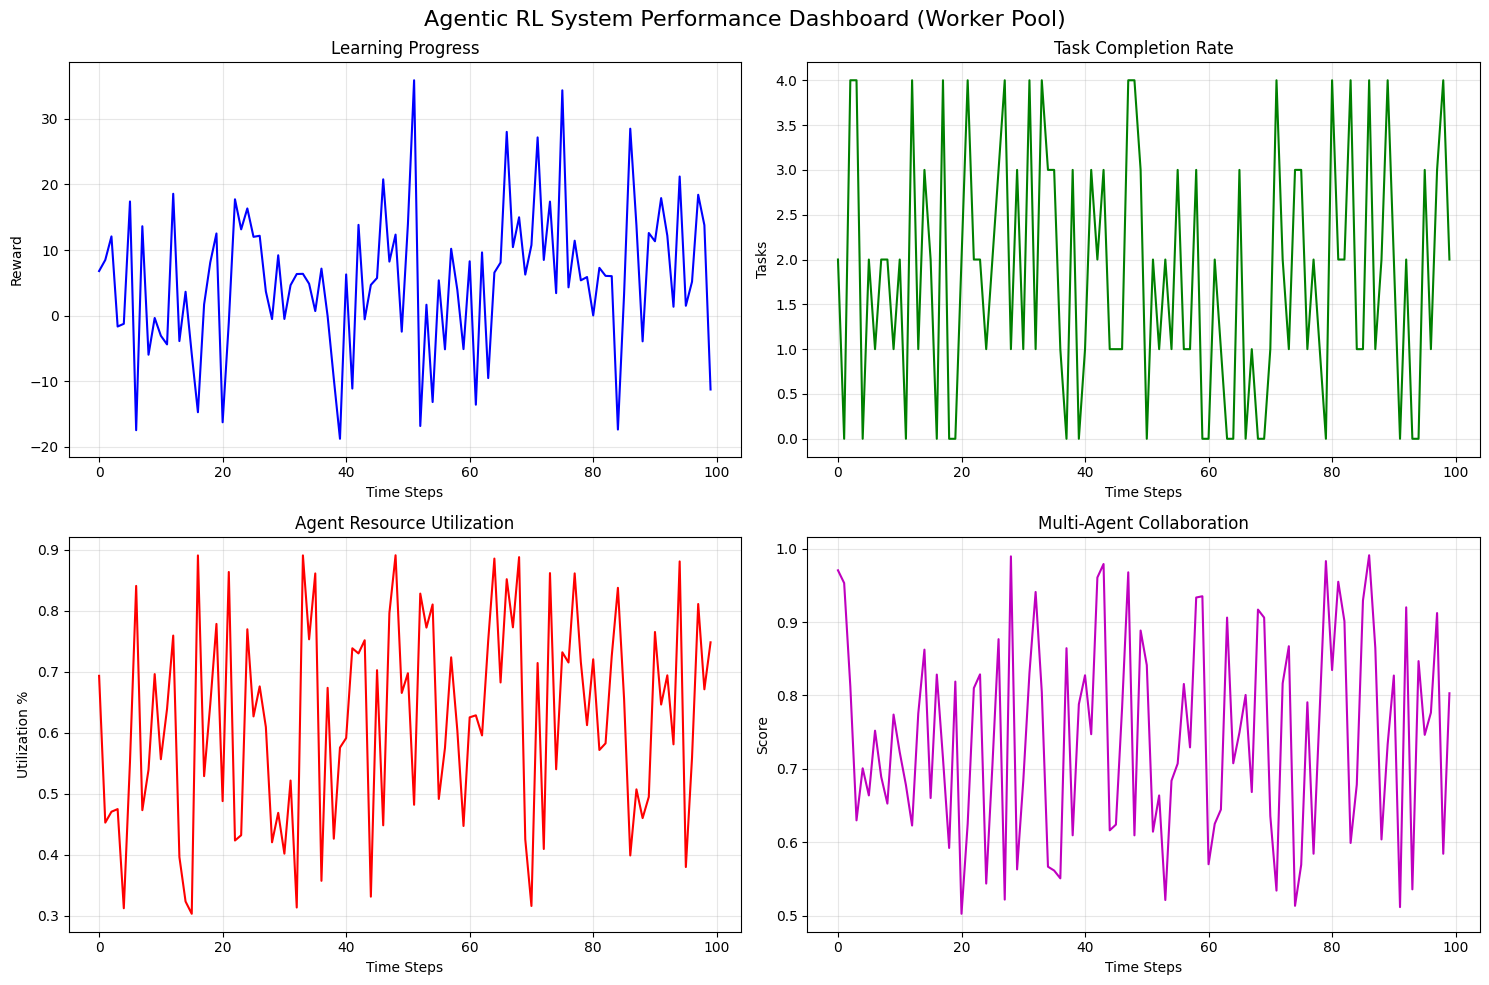


Performance Report:
                Metric       Value
0        Total Rewards  546.069297
1  Avg Task Completion    1.820000
2     Peak Utilization    0.891192
3    Avg Collaboration    0.746200
4          Total Steps  100.000000


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 10. PERFORMANCE MONITOR DEMO
# ═══════════════════════════════════════════════════════════════════════════════

monitor = PerformanceMonitor()

# Simulate metrics recording
for i in range(100):
    monitor.record_metrics(
        timestamp=i,
        env_info={"reward": np.random.randn() * 10 + i * 0.1, "completed_tasks": np.random.randint(0, 5)},
        agent_metrics={"avg_utilization": np.random.uniform(0.3, 0.9), "collaboration_score": np.random.uniform(0.5, 1.0)}
    )

# Visualize performance
monitor.plot_performance()

# Generate report
report = monitor.generate_report()
print("\nPerformance Report:")
print(report)


## Summary

This notebook provides a **complete** implementation of the Worker Pool + Semaphore pattern for multi-agent RL workflows.

### Components Included

| Component | Description |
|-----------|-------------|
| **AgentWorkerPool** | Semaphore + ThreadPoolExecutor for concurrent task execution |
| **WorkerPoolRLEnvironment** | Gymnasium environment with worker pool integration |
| **AgenticRLSystem** | PPO-based training with callbacks and checkpointing |
| **ToolRegistry** | Agent tool management with async execution |
| **SmartAgent** | Q-learning based tool selection |
| **PerformanceMonitor** | Visualization dashboard and reporting |
| **train_agentic_rl_system()** | Complete training pipeline |

### Pattern Comparison

| Aspect | Task Queue (agentic_rl_workflow) | Worker Pool + Semaphore (this notebook) |
|--------|----------------------------------|----------------------------------------|
| Submission | Push one-by-one | Submit ALL at once |
| Execution | Round-robin | True parallel |
| Concurrency | Queue emptiness | Semaphore count |
| Best For | Streaming tasks | Batch processing |

### Usage

```python
# Quick environment demo
demo_worker_pool_environment()

# Full training (takes time)
system, metrics = train_agentic_rl_system()
```
